In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


In [2]:
from data_pipeline import prepare_training_data, create_lag_features, create_rolling_features

In [3]:
# Load the data
df = pd.read_pickle('data/cleaned/data.pkl')
df_submission = pd.read_pickle('data/cleaned/submission_data.pkl')
df_climate = pd.read_pickle('data/cleaned/climate_data.pkl')
    
df_climate['date'] = pd.to_datetime(df_climate['date_time'].dt.date)

unique_dates = pd.DataFrame(pd.date_range(start='2023-10-01', end=df.date.max()), columns=['date'])
# unique_dates = pd.DataFrame(pd.date_range(start=df.date.min(), end=df.date.max()), columns=['date'])
unique_sources = pd.DataFrame(df_submission.source.drop_duplicates(), columns=['source'])
unique_dates_sources = pd.merge(unique_dates, unique_sources, how='cross')

In [5]:
# Define aggregation configurations
df_agg_config = {
    'current' : ['mean'],
    'power_factor' : ['mean'],
    'kwh' : ['sum'],
    'v_red' : ['mean'],
    'v_blue' : ['mean'],
    'v_yellow' : ['mean']
}

climate_agg_config = {
    'temp' : ['mean'],
    'dewpoint_temp' : ['mean'],
    'u_wind_comp' : ['mean'],
    'v_wind_comp' : ['mean'],
    'precipitation' : ['mean'],
    'snowfall' : ['mean'],
    'snow_cover' : ['mean']
}

# Prepare the training data
training_data, feature_cols, target_col, agg_climate = prepare_training_data(
    df, df_climate, unique_dates_sources, df_agg_config, climate_agg_config
)

# Add lag features (example: 1-day and 7-day lags for kwh_mean and temperature_mean)
# lag_cols = ['kwh_mean', 'temperature_mean']
# training_data_with_lags = create_lag_features(
#     training_data, lag_cols, [1, 7]
# )

# # Add rolling window features
# rolling_cols = ['kwh_sum', 'temperature_mean']
# training_data_with_rolling = create_rolling_features(
#     training_data, rolling_cols, [3, 7], ['mean', 'std']
# )

print(f"Original df shape: {df.shape}")
print(f"Training data shape: {training_data.shape}")
# print(f"Training data with lags shape: {training_data_with_lags.shape}")
# print(f"Training data with rolling features shape: {training_data_with_rolling.shape}")
print(f"Feature columns: {feature_cols}")
print(f"Target column: {target_col}") 

Original df shape: (39147559, 13)
Training data shape: (69646, 15)
Feature columns: ['date', 'current_mean', 'power_factor_mean', 'v_red_mean', 'v_blue_mean', 'v_yellow_mean', 'temp_mean', 'dewpoint_temp_mean', 'u_wind_comp_mean', 'v_wind_comp_mean', 'precipitation_mean', 'snowfall_mean', 'snow_cover_mean']
Target column: kwh_sum


In [6]:
agg_climate

,date,temp_mean,dewpoint_temp_mean,u_wind_comp_mean,v_wind_comp_mean,precipitation_mean,snowfall_mean,snow_cover_mean
0,2023-06-03,1.860280,-3.348664,0.025054,-0.657726,0.000414,0.000000e+00,99.972656
1,2023-06-04,3.992740,-1.905203,-0.180909,-0.505298,0.001004,0.000000e+00,99.972656
2,2023-06-05,4.794523,-3.781657,-0.145114,-0.498183,0.000482,4.858333e-08,99.972656
3,2023-06-06,6.304390,-4.670615,0.018054,-0.478623,0.000371,2.175000e-09,99.972656
4,2023-06-07,7.003922,-3.965763,0.083701,-0.516598,0.000360,0.000000e+00,99.972656
...,...,...,...,...,...,...,...,...
506,2024-10-21,3.712101,-3.217974,-0.118125,-0.373651,0.000356,0.000000e+00,1.033285
507,2024-10-22,2.515382,-2.358298,0.047106,-0.214380,0.000432,6.708750e-06,0.531738
508,2024-10-23,0.315618,-0.711822,0.001728,-0.227600,0.002350,1.128584e-03,6.653727
509,2024-10-24,-0.349515,-1.964442,0.045428,-0.506269,0.000449,1.930785e-04,9.877035


In [9]:
training_data.head(5)
training_data.to_pickle('data/cleaned/training_data.pkl')

In [14]:
agg_df = training_data.groupby(['date', 'source']).agg(kwh_sum = ('kwh_sum', 'sum')).reset_index()
agg_df = agg_df.pivot(index='date', columns='source', values='kwh_sum').reset_index()
agg_df.head(5)
# agg_df = agg_df[unique_sources.source.drop_duplicates().to_list()]

,date,source,kwh_sum
0,2023-10-01,consumer_device_12_data_user_1,0.0
1,2023-10-01,consumer_device_12_data_user_10,0.0
2,2023-10-01,consumer_device_12_data_user_11,0.0
3,2023-10-01,consumer_device_12_data_user_12,0.0
4,2023-10-01,consumer_device_12_data_user_13,0.0


In [11]:
print(exog.shape)
print(Y.shape)

(511, 7)
(479, 194)


In [21]:
training_data[['date', 'source', 'kwh_sum']].pivot(index='date', columns='source', values='kwh_sum').reset_index().drop(columns = ['date']).to_numpy()


array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [0.21195427, 0.15477929, 0.05354679, ..., 0.16209729, 0.19321056,
        0.25562017],
       [0.05995667, 0.04154606, 0.02002134, ..., 0.14410179, 0.17862409,
        0.23655887],
       [0.19012027, 0.13149823, 0.037945  , ..., 0.19545766, 0.21263652,
        0.29553819]])

In [46]:
from statsmodels.tsa.statespace.varmax import VARMAX

exog = training_data.loc[training_data.source == 'consumer_device_12_data_user_1',['temp_mean', 'dewpoint_temp_mean',	'u_wind_comp_mean',	
                     'v_wind_comp_mean',	'precipitation_mean',	'snowfall_mean',
                     'snow_cover_mean']].copy().to_numpy()

Y = training_data[['date', 'source', 'kwh_sum']].pivot(index='date', columns='source', values='kwh_sum').reset_index().drop(columns = ['date']).fillna(0)
Y = Y.iloc[:,:4].to_numpy()
print(exog.shape)
print(Y.shape)
# Choose an autoregressive order, e.g., p=1 or p=2 (you might need to test for optimal lag).
p = 1

# Fit the VARMAX model.
model = VARMAX(Y, exog=exog, order=(p, 0))
result = model.fit(maxiter=2000, disp=False)
print(result.summary())

(359, 7)
(359, 4)
                              Statespace Model Results                              
Dep. Variable:     ['y1', 'y2', 'y3', 'y4']   No. Observations:                  359
Model:                              VARX(1)   Log Likelihood                5620.398
                                + intercept   AIC                         -11124.795
Date:                      Sun, 09 Mar 2025   BIC                         -10899.563
Time:                              19:47:14   HQIC                        -11035.229
Sample:                                   0                                         
                                      - 359                                         
Covariance Type:                        opg                                         
Ljung-Box (L1) (Q):          25.03, 0.27, 0.00, 0.31   Jarque-Bera (JB):   5433.79, 28820.47, 3809.62, 4143.61
Prob(Q):                      0.00, 0.61, 0.97, 0.58   Prob(JB):                        0.00, 0.00, 0.00, 

/Users/jonathanbugg/Desktop/zindi_hydro_pred/zindi_hydropower_prediction/.venv/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [42]:
Y[:-50,:]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00886259, 0.00678749, 0.        , ..., 0.78560746, 0.98633917,
        0.00796983],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [47]:
print(np.sqrt(np.mean((result.fittedvalues-Y)**2)))

print(np.sqrt(np.mean((result.fittedvalues[:-50,:]-Y[:-50,:])**2)))

0.023630017074456174
0.01361551435529349


In [48]:
result.forecast(steps = 30)

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

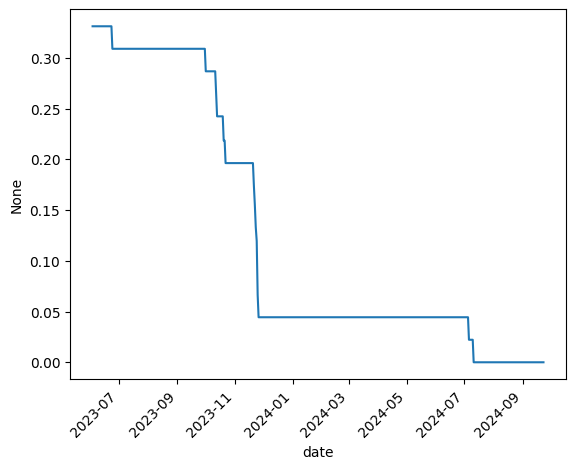

In [ ]:
perc_na = agg_df.isna().sum(axis=1) / agg_df.shape[1]
sns.lineplot(x = unique_dates.date, y = perc_na)
agg_df[unique_sources.source.drop_duplicates().to_list()].isna().sum(axis=1) / agg_df.shape[1]
plt.xticks(rotation=45, ha='right')
plt.show()





In [59]:
agg_df_filled = agg_df.fillna(0)

perc_zero_na = (agg_df_filled < 0.01).sum(axis=1) / agg_df_filled.shape[1]
perc_zero_na_df = pd.DataFrame({
    'date': unique_dates.date,
    'perc_zero': perc_zero_na
})
perc_zero_na_df[perc_zero_na_df.perc_zero < 1.0]


,date,perc_zero
120,2023-10-01,0.932990
121,2023-10-02,0.932990
122,2023-10-03,0.932990
123,2023-10-04,0.932990
124,2023-10-05,0.932990
...,...,...
474,2024-09-19,0.170103
475,2024-09-20,0.118557
476,2024-09-21,0.180412
477,2024-09-22,0.175258


In [52]:
unique_dates.date.shape, perc_zero_na.T.shape

((479,), (479,))